#### Amazon Prime Churn and Segmentation Analysis

 #### Column Names
 
User ID, Name, Email Address, Username:  User identifiers.

Date of Birth, Gender, Location: Demographic details.

Membership Start/End Date, Subscription Plan: Subscription-related information.

Payment Information, Renewal Status: Payment and renewal status.

Usage Frequency, Purchase History, Favorite Genres: Usage and preferences.

Devices Used, Engagement Metrics, Feedback Ratings: Engagement and feedback details.

Customer Support Interactions: Customer support data.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
sns.set()
import warnings
warnings.filterwarnings("ignore")

# Reading the dataset
file_path = 'updated_amazon_prime_users (1) - Copy.csv'
df = pd.read_csv(file_path, sep=';')

# Displaying first few rows of the dataset for an overview
df.head(), df.shape


(   User ID              Name                   Email Address  \
 0        1     Ronald Murphy      williamholland@example.com   
 1        2       Scott Allen             scott22@example.org   
 2        3  Jonathan Parrish            brooke16@example.org   
 3        4    Megan Williams         elizabeth31@example.net   
 4        5     Kathryn Brown  pattersonalexandra@example.org   
 
              Username Date of Birth  Gender        Location  \
 0      williamholland      3/6/1953    Male  Rebeccachester   
 1             scott22      8/7/1978    Male   Mcphersonview   
 2            brooke16     6/12/1994  Female       Youngfort   
 3         elizabeth31    22/12/1964  Female    Feliciashire   
 4  pattersonalexandra      4/6/1961    Male    Port Deborah   
 
   Membership Start Date Membership End Date Subscription Plan  \
 0             15/1/2024           14/1/2025            Annual   
 1              7/1/2022            6/1/2023           Monthly   
 2             13/4/2022

In [2]:
# Renaming columns for consistency
df.rename(columns={
    'User ID': 'User_ID',
    'Email Address': 'Email_Address',
    'Date of Birth': 'Date_of_Birth',
    'Membership Start Date': 'Membership_Start_Date',
    'Membership End Date': 'Membership_End_Date',
    'Subscription Plan': 'Subscription_Plan',
    'Payment Information': 'Payment_Information',
    'Renewal Status': 'Renewal_Status',
    'Usage Frequency': 'Usage_Frequency',
    'Purchase History': 'Purchase_History',
    'Favorite Genres': 'Favorite_Genres',
    'Devices Used': 'Devices_Used',
    'Engagement Metrics': 'Engagement_Metrics',
    'Customer Support Interactions': 'Customer_Support_Interactions',
    'Feedback/Ratings': 'Feedback_Ratings'
}, inplace=True)

# Converting dates to datetime format with dayfirst=True
df['Date_of_Birth'] = pd.to_datetime(df['Date_of_Birth'], dayfirst=True, errors='coerce')
df['Membership_Start_Date'] = pd.to_datetime(df['Membership_Start_Date'], errors='coerce', dayfirst=True)
df['Membership_End_Date'] = pd.to_datetime(df['Membership_End_Date'], errors='coerce', dayfirst=True)

# Creating 'churn' feature: 1 if Membership End Date is before current date, otherwise 0
current_date = datetime.now()
df['churn'] = df['Membership_End_Date'].apply(lambda x: 1 if pd.notnull(x) and x < current_date else 0)

# Calculating missing data percentage
missing_data_percentage = round(df.isnull().sum() / df.shape[0] * 100, 2)

# Display missing data percentage
missing_data_percentage


User_ID                          0.00
Name                             0.00
Email_Address                    0.00
Username                         0.00
Date_of_Birth                    0.00
Gender                           0.00
Location                         0.00
Membership_Start_Date            0.04
Membership_End_Date              0.00
Subscription_Plan                0.00
Payment_Information              0.00
Renewal_Status                   0.00
Usage_Frequency                  0.00
Purchase_History                 0.00
Favorite_Genres                  0.00
Devices_Used                     0.00
Engagement_Metrics               0.00
Feedback_Ratings                 0.00
Customer_Support_Interactions    0.00
churn                            0.00
dtype: float64

In [3]:
# Create Membership Duration feature
df['Membership_Duration_Days'] = (df['Membership_End_Date'] - df['Membership_Start_Date']).dt.days

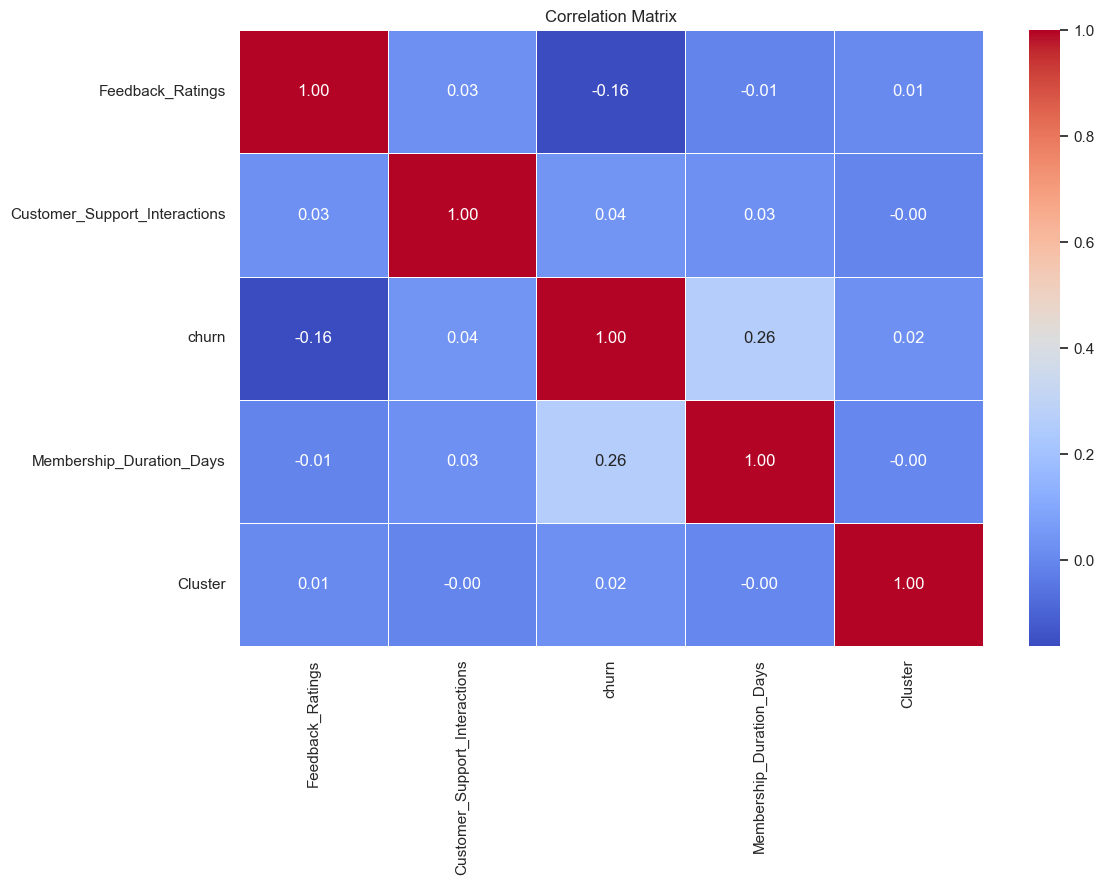

In [16]:
# Correlation chart
plt.figure(figsize=(12, 8))
sns.heatmap(df.drop(columns = ["User_ID"]).corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()






Membership Duration and Churn (0.26)

Membership duration is positively related to churn. This suggests that users with lengthier memberships will eventually churn. While the association is not great, it is the most obvious positive correlation with churn in this matrix.


## CHURN DISTRIBUTION

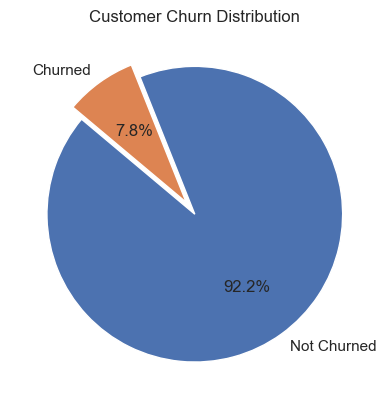

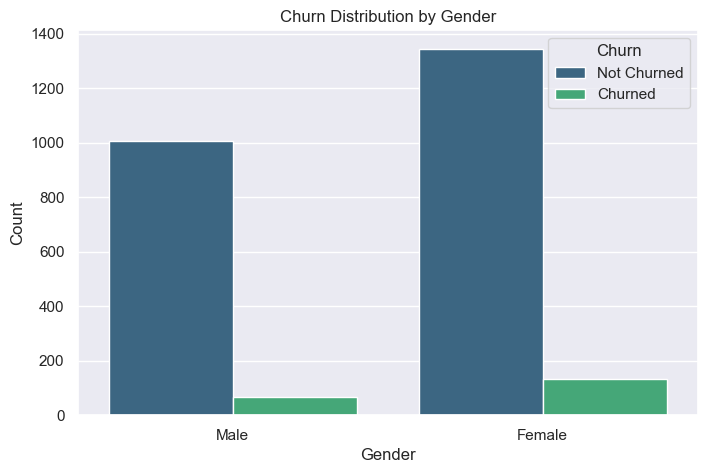

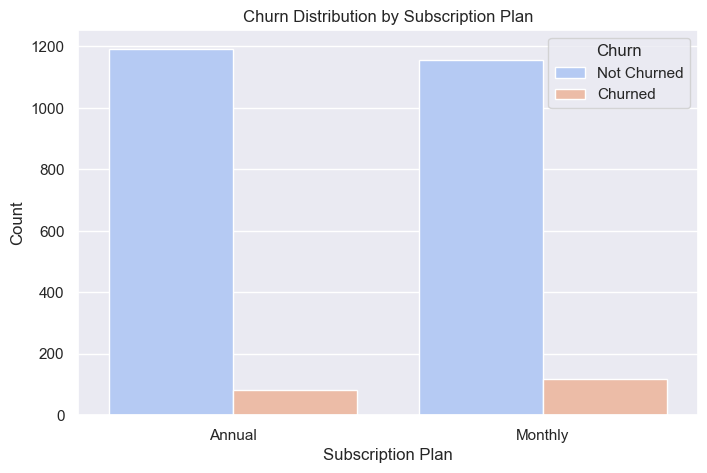

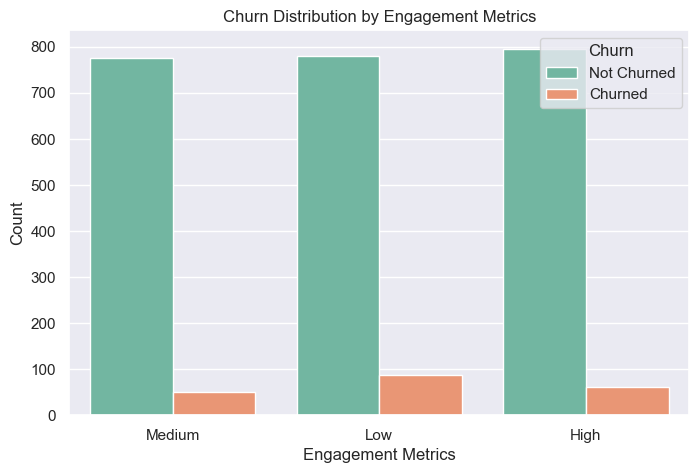

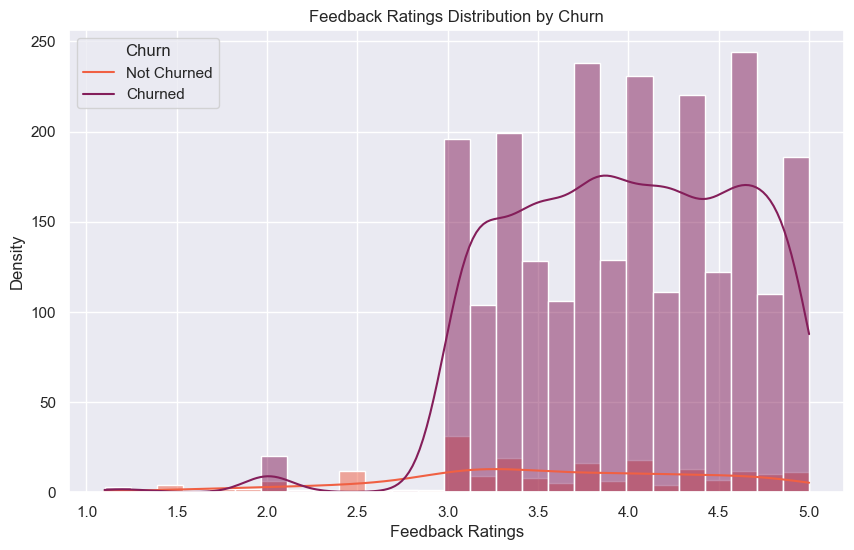

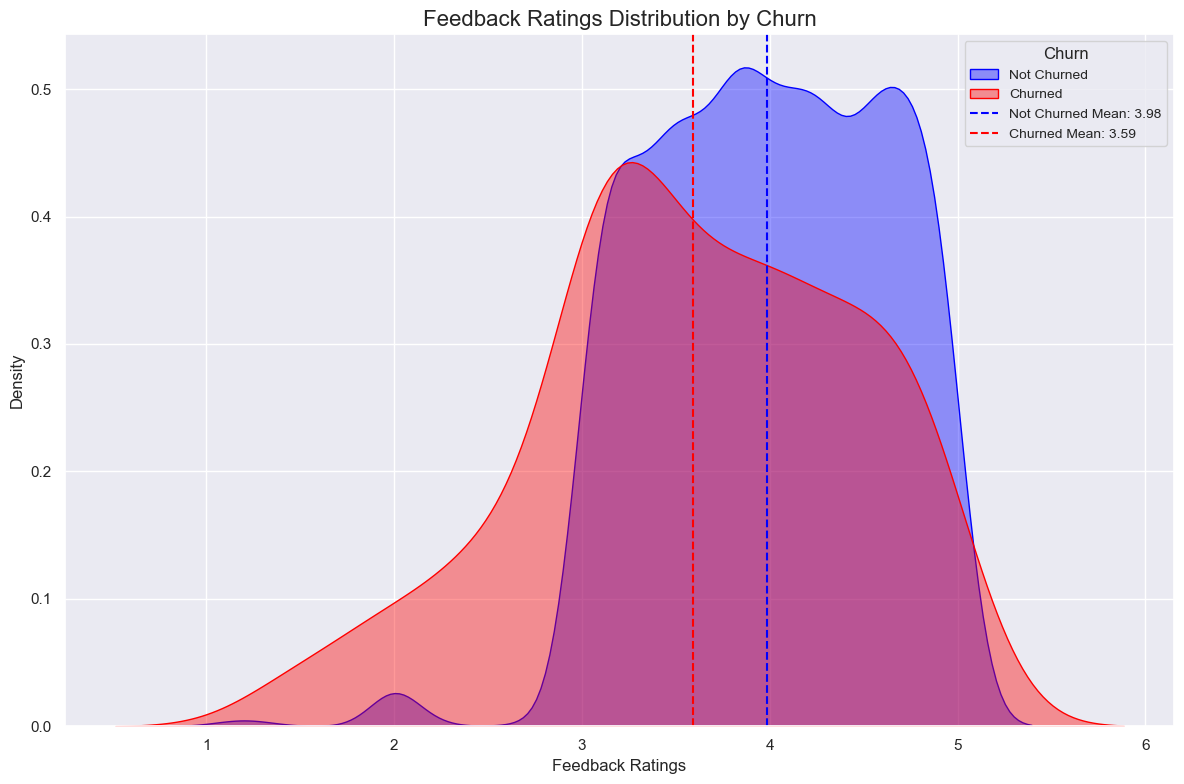

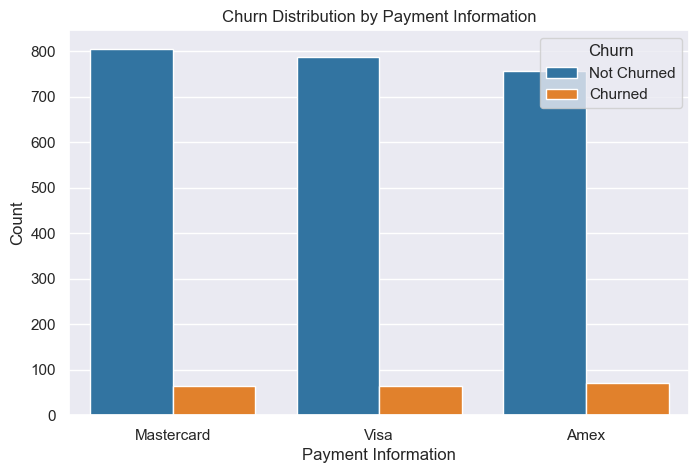

In [5]:
# Churn distribution pie chart
churn_counts = df['churn'].value_counts()
labels = ['Not Churned', 'Churned']
plt.pie(churn_counts, labels=labels, autopct='%1.1f%%', startangle=140, explode=(0, 0.1))
plt.title('Customer Churn Distribution')
plt.show()

# Gender vs. Churn
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Gender', hue='churn', palette='viridis')
plt.title('Churn Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['Not Churned', 'Churned'])
plt.show()

# Subscription Plan vs. Churn
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Subscription_Plan', hue='churn', palette='coolwarm')
plt.title('Churn Distribution by Subscription Plan')
plt.xlabel('Subscription Plan')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['Not Churned', 'Churned'])
plt.show()

# Engagement Metrics vs. Churn
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Engagement_Metrics', hue='churn', palette='Set2')
plt.title('Churn Distribution by Engagement Metrics')
plt.xlabel('Engagement Metrics')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['Not Churned', 'Churned'])
plt.show()

# Feedback Ratings Density
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Feedback_Ratings', hue='churn', kde=True, palette='rocket')
plt.title('Feedback Ratings Distribution by Churn')
plt.xlabel('Feedback Ratings')
plt.ylabel('Density')
plt.legend(title='Churn', labels=['Not Churned', 'Churned'])
plt.show()

plt.figure(figsize=(12, 8))

# Plot separate density plots for churned and not churned customers
sns.kdeplot(data=df[df['churn'] == 0], x='Feedback_Ratings', label='Not Churned', color='blue', fill=True, alpha=0.4)
sns.kdeplot(data=df[df['churn'] == 1], x='Feedback_Ratings', label='Churned', color='red', fill=True, alpha=0.4)

# Add mean lines for each category
not_churned_mean = df[df['churn'] == 0]['Feedback_Ratings'].mean()
churned_mean = df[df['churn'] == 1]['Feedback_Ratings'].mean()
plt.axvline(not_churned_mean, color='blue', linestyle='--', label=f'Not Churned Mean: {not_churned_mean:.2f}')
plt.axvline(churned_mean, color='red', linestyle='--', label=f'Churned Mean: {churned_mean:.2f}')

# Add chart title and labels
plt.title('Feedback Ratings Distribution by Churn', fontsize=16)
plt.xlabel('Feedback Ratings', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Churn', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()



# Payment Information vs. Churn
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Payment_Information', hue='churn', palette='tab10')
plt.title('Churn Distribution by Payment Information')
plt.xlabel('Payment Information')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['Not Churned', 'Churned'])
plt.show()


### Insights from the Charts:

#### Churn Distribution:
Only 7.8% of customers have churned, which indicates that Amazon Prime has a high retention rate, with 92.2% of customers remaining active.
The significant proportion of "Not Churned" users suggests that Amazon Prime's services and benefits are compelling enough to keep the majority of subscribers loyal.

#### Gender and Churn:
proportion of churned customers seems slightly higher for females compared to males..

Targeted Discounts: Provide personalized discounts or exclusive deals on categories commonly purchased by female subscribers, such as fashion, beauty, or household items.

#### Subscription Plans and Churn:
Lower Churn for Annual Subscribers:

Annual subscribers have a noticeably smaller churn count compared to monthly subscribers, indicating higher loyalty among customers on an annual plan.
This could be due to a longer commitment period and upfront payment, which discourages churn.

Higher Churn for Monthly Subscribers:

Monthly subscribers exhibit a higher churn count. This could be because monthly plans offer more flexibility to cancel and are likely to attract customers who are less committed or exploring the service.

Offering discounts or incentives for annual subscriptions may reduce churn.

Flexibility to Upgrade:
Provide an easy upgrade path for monthly subscribers to switch to annual plans without losing current benefits or paying additional fees.

#### Engagement Metrics and Churn:
Low Engagement: Subscribers with low engagement show the highest churn rate among the three groups, emphasizing the importance of user activity in retention. Improve engagement through personalized content recommendations

#### Feedback Ratings and Churn:
The mean feedback rating for non-churned users is 3.98, while for churned users, it is lower at 3.59.
This indicates that customers who provide higher feedback ratings are less likely to churn, suggesting a positive relationship between user satisfaction and retention.

Low Feedback Ratings are Linked to Churn:

A noticeable concentration of churned users occurs at the lower end of the feedback ratings (below 3), suggesting dissatisfaction may lead to higher churn likelihood.


Focus on Low-Rating Users:

Identify and address the concerns of users who provide ratings below 3, as they are at a higher risk of churning.
Use targeted surveys or direct outreach to understand and resolve their issues.


#### Renewal Status and Churn:
Manual renewal status is associated with higher churn.This could be due to the extra effort required to renew.
Encouraging auto-renewals could improve retention.


#### Customer Support Interactions and Churn:
Low Churn Density:

Churned users show very low density across all interaction levels. This indicates that while some churned users may interact with support, they are a small subset, and support interactions alone are not a primary indicator of churn.
While the churn density remains low overall, churned users are present even at high levels of customer support interactions

Analyze the nature of issues for users with high support interactions. Are their concerns related to specific features, services, or technical problems? 



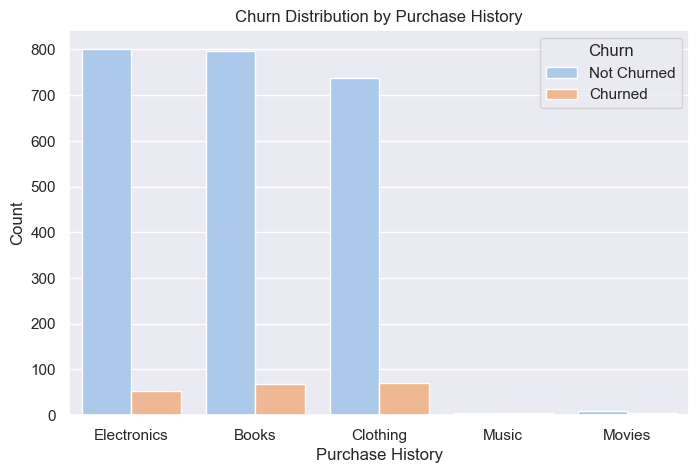

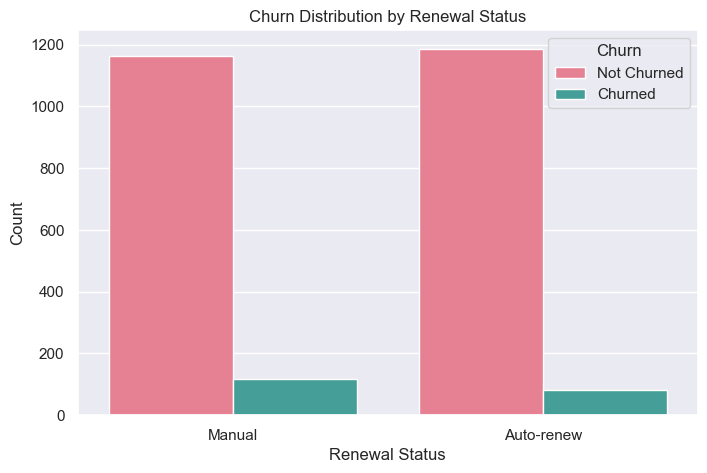

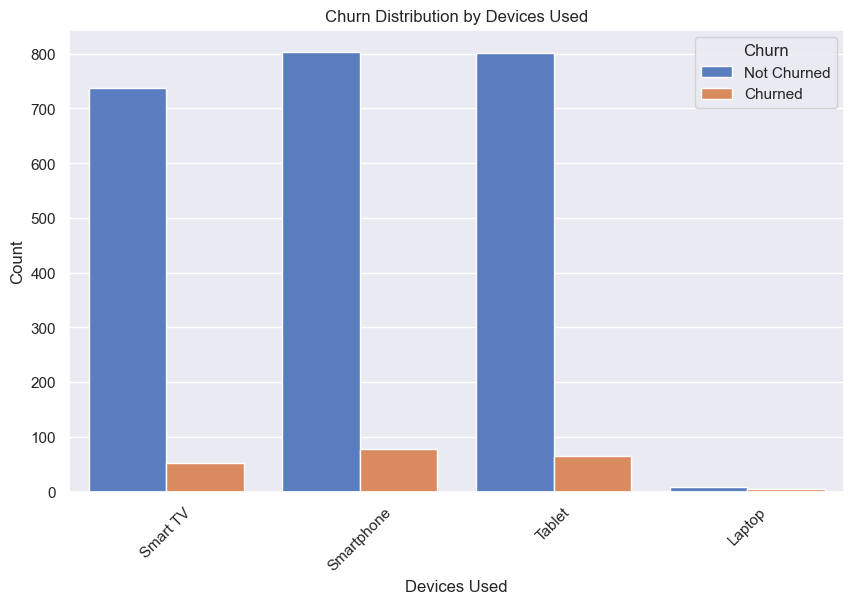

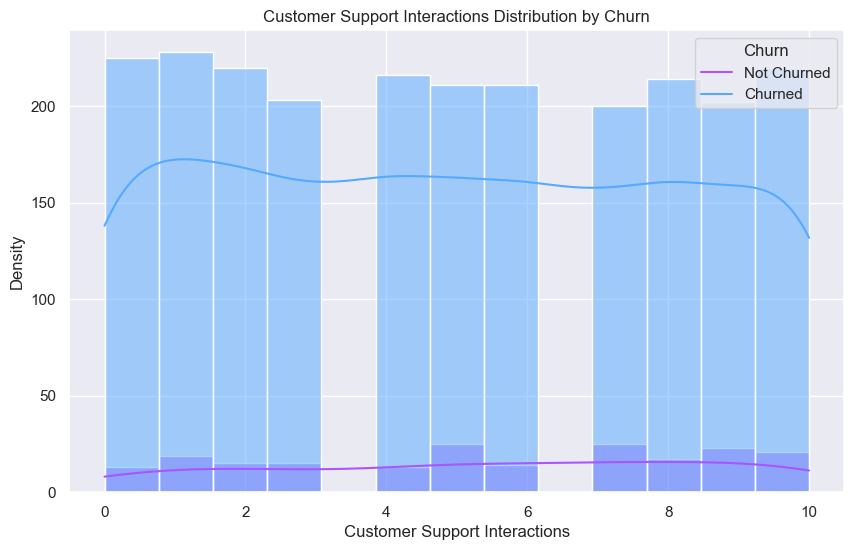

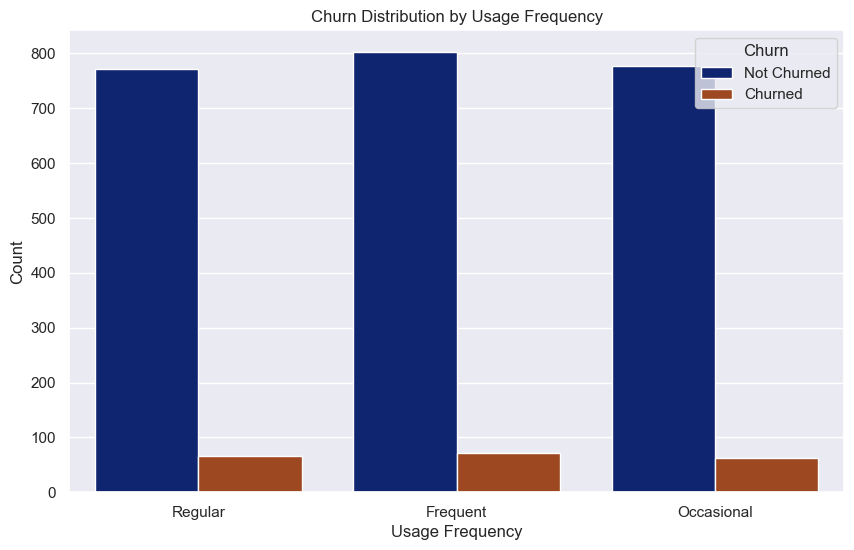

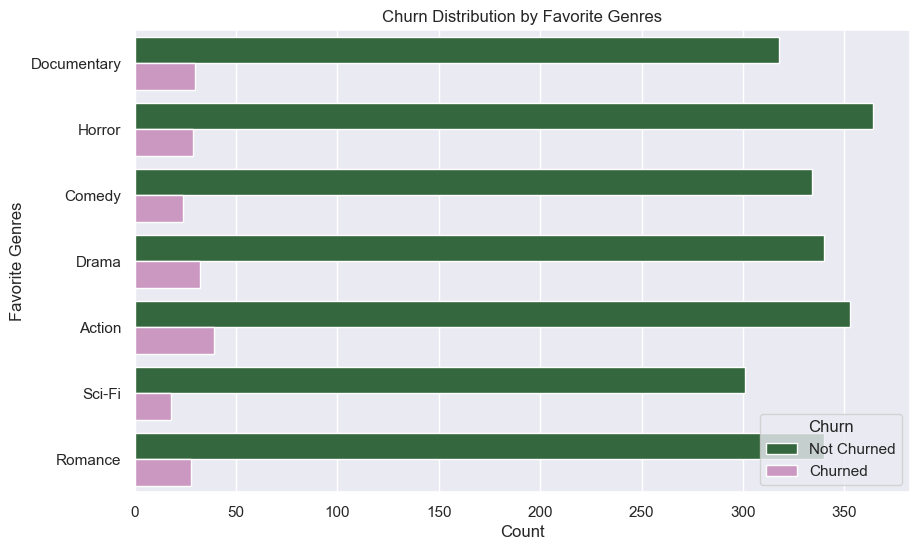

In [6]:
# Purchase History vs. Churn
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Purchase_History', hue='churn', palette='pastel')
plt.title('Churn Distribution by Purchase History')
plt.xlabel('Purchase History')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['Not Churned', 'Churned'])
plt.show()

# Renewal Status vs. Churn
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Renewal_Status', hue='churn', palette='husl')
plt.title('Churn Distribution by Renewal Status')
plt.xlabel('Renewal Status')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['Not Churned', 'Churned'])
plt.show()

# Devices Used vs. Churn
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Devices_Used', hue='churn', palette='muted')
plt.title('Churn Distribution by Devices Used')
plt.xlabel('Devices Used')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Churn', labels=['Not Churned', 'Churned'])
plt.show()

# Customer Support Interactions vs. Churn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Customer_Support_Interactions', hue='churn', kde=True, palette='cool')
plt.title('Customer Support Interactions Distribution by Churn')
plt.xlabel('Customer Support Interactions')
plt.ylabel('Density')
plt.legend(title='Churn', labels=['Not Churned', 'Churned'])
plt.show()

# Usage Frequency vs. Churn
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Usage_Frequency', hue='churn', palette='dark')
plt.title('Churn Distribution by Usage Frequency')
plt.xlabel('Usage Frequency')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['Not Churned', 'Churned'])
plt.show()

# Favorite Genres vs. Churn
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Favorite_Genres', hue='churn', palette='cubehelix')
plt.title('Churn Distribution by Favorite Genres')
plt.xlabel('Count')
plt.ylabel('Favorite Genres')
plt.legend(title='Churn', labels=['Not Churned', 'Churned'])
plt.show()


### General Recommendations:

#### Retention Strategies:

Offer incentives for annual subscriptions and encourage auto-renewals.
Improve engagement metrics through personalized content or notifications.
Address customer concerns proactively with efficient support systems.

#### Targeted Interventions:

Focus retention efforts on users with low engagement and frequent manual renewals.
Address satisfaction issues among customers providing low feedback ratings.




### MODEL DEPLOYMENT

In [7]:
# Splitting the dataset into features and target variable
# Encoding categorical variables
df_encoded = df.copy()
categorical_cols = df_encoded.select_dtypes(include='object').columns
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))


# Define features and target variable
X = df_encoded.drop(columns=['churn', 'Date_of_Birth', 'Membership_Start_Date', 'Membership_End_Date','User_ID','Membership_Duration_Days','Email_Address','Username','Name'])
y = df_encoded['churn']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Model 1: Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Model 2: Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=500)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Evaluation Metrics for both models
rf_accuracy = accuracy_score(y_test, rf_predictions)
lr_accuracy = accuracy_score(y_test, lr_predictions)

# Confusion Matrices
rf_cm = confusion_matrix(y_test, rf_predictions)
lr_cm = confusion_matrix(y_test, lr_predictions)

# Classification Reports
rf_report = classification_report(y_test, rf_predictions)
lr_report = classification_report(y_test, lr_predictions)

# Display Results
print("Random Forest Accuracy:", rf_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)
#print("\nRandom Forest Confusion Matrix:\n", rf_cm)
#print("\nLogistic Regression Confusion Matrix:\n", lr_cm)
print("\nRandom Forest Classification Report:\n", rf_report)
print("\nLogistic Regression Classification Report:\n", lr_report)

Random Forest Accuracy: 0.9215686274509803
Logistic Regression Accuracy: 0.9215686274509803

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       705
           1       0.50      0.05      0.09        60

    accuracy                           0.92       765
   macro avg       0.71      0.52      0.52       765
weighted avg       0.89      0.92      0.89       765


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       705
           1       0.00      0.00      0.00        60

    accuracy                           0.92       765
   macro avg       0.46      0.50      0.48       765
weighted avg       0.85      0.92      0.88       765



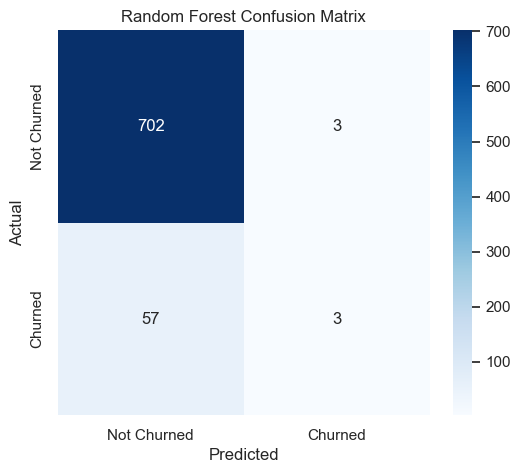

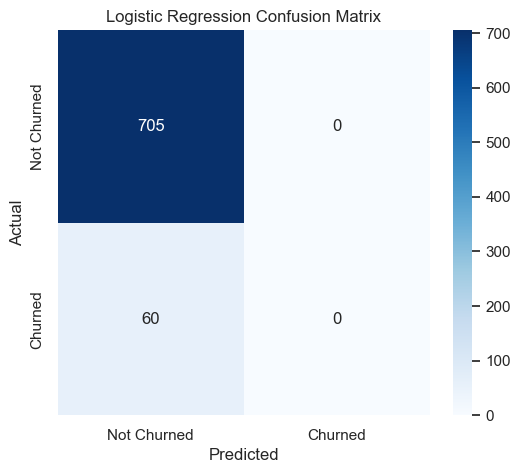

In [8]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(rf_cm, 'Random Forest Confusion Matrix')

# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(lr_cm, 'Logistic Regression Confusion Matrix')


### Model Evaluation Results:

#### Random Forest Classifier:

True Positives (Churn Predicted Correctly): 3
True Negatives (Not Churn Predicted Correctly): 702
False Positives (Incorrectly Predicted as Churn): 3
False Negatives (Incorrectly Predicted as Not Churn): 57
    
#### Logistic Regression:

True Positives (Churn Predicted Correctly): 0
True Negatives (Not Churn Predicted Correctly): 705
False Positives (Incorrectly Predicted as Churn): 0
False Negatives (Incorrectly Predicted as Not Churn): 60
    



Gradient Boosting Accuracy: 0.9228758169934641

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       705
           1       0.56      0.08      0.14        60

    accuracy                           0.92       765
   macro avg       0.74      0.54      0.55       765
weighted avg       0.90      0.92      0.90       765



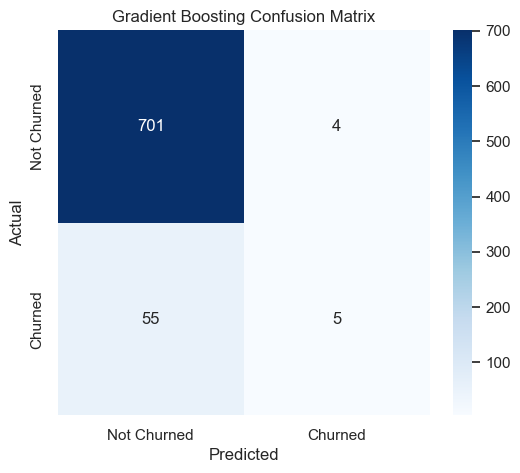


Comparison of Model Accuracies:
Random Forest Accuracy: 0.9216
Logistic Regression Accuracy: 0.9216
Gradient Boosting Accuracy: 0.9229


In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Gradient Boosting Model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

# Evaluation Metrics for Gradient Boosting
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_cm = confusion_matrix(y_test, gb_predictions)
gb_report = classification_report(y_test, gb_predictions)

# Display Results
print("\nGradient Boosting Accuracy:", gb_accuracy)
print("\nGradient Boosting Classification Report:\n", gb_report)

# Plot Confusion Matrix for Gradient Boosting
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(gb_cm, 'Gradient Boosting Confusion Matrix')

# Compare Performance
print("\nComparison of Model Accuracies:")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")


#### Gradient Boosting
True Positives (Churn Predicted Correctly): 5
True Negatives (Not Churn Predicted Correctly): 701
False Positives (Incorrectly Predicted as Churn): 4
False Negatives (Incorrectly Predicted as Not Churn): 55

### Best Model: Gradient Boosting
Best Model: Gradient Boosting.
It outperforms Random Forest and Logistic Regression in precision, recall, and F1-score

In [19]:
# Ensure predictions and indexes align with the original data
gb_predicted_to_churn = X_test[gb_predictions == 1]

# Adding customer details for better interpretation
customers_predicted_to_churn_gb = df.loc[gb_predicted_to_churn.index]

# Display the customers predicted to churn
print("Customers Predicted to Churn by Gradient Boosting:")
customers_predicted_to_churn_gb.head()


Customers Predicted to Churn by Gradient Boosting:


,User_ID,Name,Email_Address,Username,Date_of_Birth,Gender,Location,Membership_Start_Date,Membership_End_Date,Subscription_Plan,...,Usage_Frequency,Purchase_History,Favorite_Genres,Devices_Used,Engagement_Metrics,Feedback_Ratings,Customer_Support_Interactions,churn,Membership_Duration_Days,Cluster
2508,2509,Kristen Brown,cassandra60@gmail.com,nmedina,1983-03-28,Male,South Stephanieburgh,2023-01-07,2023-06-10,Monthly,...,Frequent,Books,Documentary,Laptop,High,1.4,4,1,154.0,1
2510,2511,Elizabeth Olson,ldiaz@yahoo.com,alvarezdavid,1958-02-14,Male,West Lisaborough,2024-02-08,2027-06-25,Monthly,...,Regular,Movies,Horror,Smart TV,Medium,2.1,2,0,1233.0,1
1891,1892,Julie Perry,fordjoseph@example.net,fordjoseph,1988-10-25,Male,South Melanie,2022-03-01,2024-03-01,Annual,...,Frequent,Clothing,Horror,Smartphone,Low,2.5,1,1,731.0,0
2530,2531,Tina Martinez,flove@gill.com,rmoss,1957-05-30,Female,Tanyabury,2023-03-28,2024-06-08,Annual,...,Frequent,Books,Drama,Smart TV,Medium,1.8,8,1,438.0,3
1852,1853,Heather Munoz,vmedina@example.org,vmedina,1964-08-05,Female,South Maryborough,2024-02-01,2024-10-31,Monthly,...,Frequent,Clothing,Drama,Smartphone,Low,2.1,10,1,273.0,2



Feature Importances from Gradient Boosting:

                          Feature  Importance
10               Feedback_Ratings    0.468133
1                        Location    0.293061
11  Customer_Support_Interactions    0.055288
6                Purchase_History    0.038713
7                 Favorite_Genres    0.025752
0                          Gender    0.025146
5                 Usage_Frequency    0.022419
8                    Devices_Used    0.022162
9              Engagement_Metrics    0.017580
2               Subscription_Plan    0.015410
3             Payment_Information    0.010702
4                  Renewal_Status    0.005633


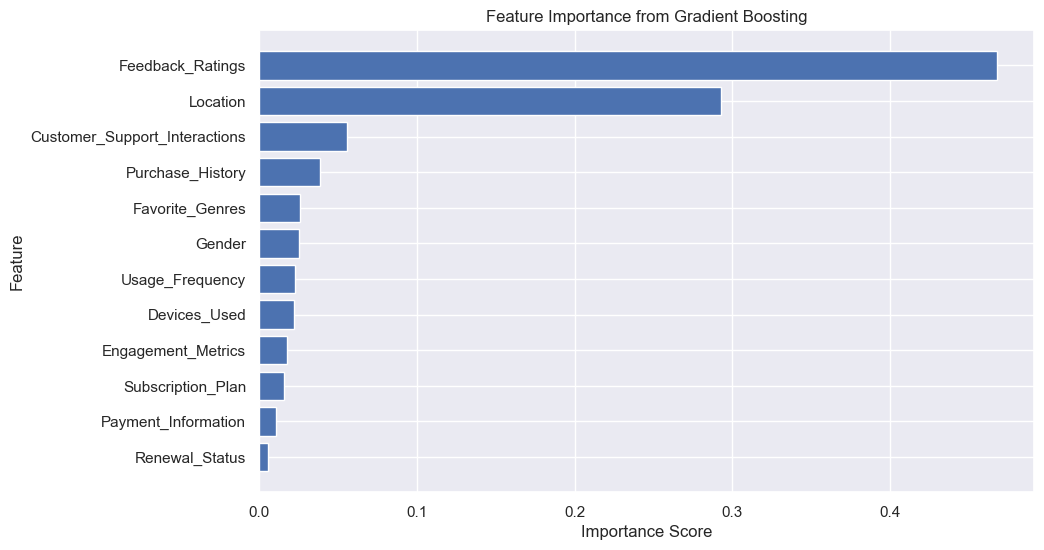

In [11]:
# Calculate feature importances from the Gradient Boosting model
gb_feature_importances = gb_model.feature_importances_

# Create a DataFrame to organize the importance scores
gb_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print("\nFeature Importances from Gradient Boosting:\n")
print(gb_feature_importance_df)

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(gb_feature_importance_df['Feature'], gb_feature_importance_df['Importance'], align='center')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance from Gradient Boosting')
plt.show()


## SEGMENTATION

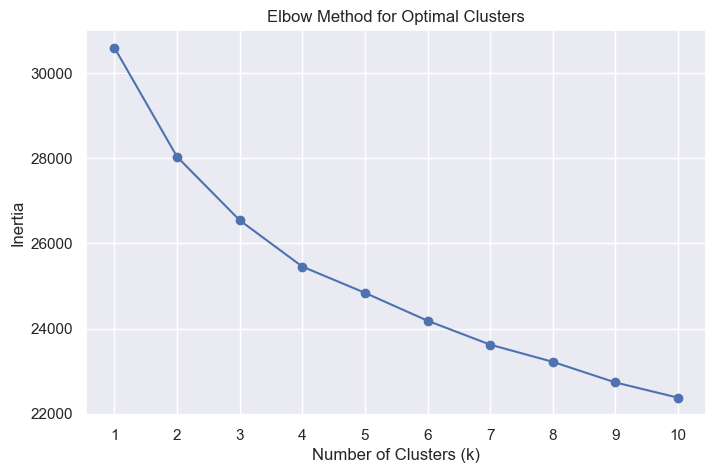

In [12]:
# Removing datetime columns from the clustering data
X_clustering = X.drop(columns=['Date_of_Birth', 'Membership_Start_Date', 'Membership_End_Date'], errors='ignore')

# Standardizing the clustering data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# Determining the optimal number of clusters using the Elbow Method
inertia = []  # List to store inertia for each k
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [13]:
# Applying KMeans clustering with 4 clusters
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, max_iter=300)
clusters = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to the original DataFrame
df['Cluster'] = clusters

# Summarizing cluster characteristics
cluster_summary = df.groupby('Cluster').mean()

# Displaying the cluster summary directly
print("Customer Cluster Summary:")
print(cluster_summary)

Customer Cluster Summary:
             User_ID  Feedback_Ratings  Customer_Support_Interactions  \
Cluster                                                                 
0        1258.583333          3.959444                       5.068519   
1        1320.393597          3.969680                       4.902072   
2        1225.098516          3.903239                       4.902834   
3        1306.182927          3.990379                       5.016260   

            churn  Membership_Duration_Days  
Cluster                                      
0        0.068519                384.696296  
1        0.054614                379.832392  
2        0.109312                382.472973  
3        0.071816                383.020325  


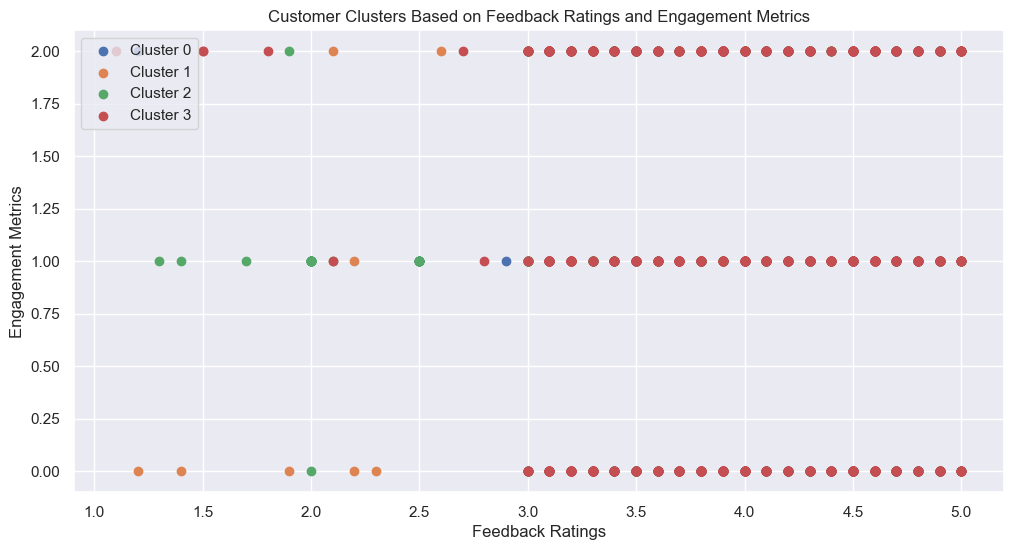

In [14]:
# Ensure that the dataset includes the cluster assignments
df_clustered = pd.concat([X, pd.DataFrame({'Cluster': clusters})], axis=1)

# Visualizing the clusters using Feedback Ratings and Engagement Metrics
plt.figure(figsize=(12, 6))

for cluster in range(optimal_k):
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
    plt.scatter(cluster_data['Feedback_Ratings'], cluster_data['Engagement_Metrics'], label=f'Cluster {cluster}')

plt.title('Customer Clusters Based on Feedback Ratings and Engagement Metrics')
plt.xlabel('Feedback Ratings')
plt.ylabel('Engagement Metrics')
plt.legend()
plt.grid(True)
plt.show()


#### Cluster 0 (Low Feedback, Low Engagement):

Customers in this cluster show low feedback ratings (1.0–2.0) and low engagement (0.0–1.0).
These are likely the most at-risk customers, as they show dissatisfaction and lack of interaction.

#### Cluster 1 (Mixed Feedback, Medium Engagement):

Includes customers with medium feedback ratings (2.0–4.0) and moderate engagement (1.0).
This group is moderately active and somewhat satisfied but could be influenced to stay or churn depending on their experience.

#### Cluster 2 (Low Feedback, High Engagement):

This group consists of customers with low feedback ratings (1.0–3.0) but high engagement (2.0).
These customers are dissatisfied but still highly engaged, possibly due to a strong need for specific services.

#### Cluster 3 (High Feedback, High Engagement):

Customers here show high feedback ratings (4.0–5.0) and high engagement (2.0).
This is the ideal customer segment with strong satisfaction and consistent activity.

#### Strategic Actions for Each Cluster

Cluster 0:  retention strategies such as reaching out to them, discounts,personalized offers or surveys to understand their dissatisfaction and improve their experience.
    
Cluster 1: Same as Cluster 0, they have similar issues. Provide targeted campaigns to increase satisfaction, such as promoting features aligned with their interests or offering incentives for higher engagement..
    
Cluster 2: Address dissatisfaction through proactive customer support or improvements to service quality.
These users are engaged but may churn if their concerns are not resolved. 
    
Cluster 3: Must keep customers by offering loyalty programs, exclusive content, or premium benefits to maintain their engagement.

In [15]:
# Adding cluster labels to the full dataset for customer identification
df['Cluster'] = clusters

# Grouping customers by cluster
customers_by_cluster = {f"Cluster {i}": df[df['Cluster'] == i] for i in range(optimal_k)}

# Displaying a sample of customers in Cluster 0
print("Sample Customers from Cluster 0:")
print(customers_by_cluster['Cluster 0'].head())


Sample Customers from Cluster 0:
    User_ID           Name                   Email_Address  \
0         1  Ronald Murphy      williamholland@example.com   
1         2    Scott Allen             scott22@example.org   
4         5  Kathryn Brown  pattersonalexandra@example.org   
7         8    James Smith          adrienne49@example.org   
14       15  Melanie Burns          meyerstacy@example.net   

              Username Date_of_Birth Gender             Location  \
0       williamholland    1953-06-03   Male       Rebeccachester   
1              scott22    1978-07-08   Male        Mcphersonview   
4   pattersonalexandra    1961-06-04   Male         Port Deborah   
7           adrienne49    1946-10-04   Male  West Matthewborough   
14          meyerstacy    2003-04-07   Male       East Janetfurt   

   Membership_Start_Date Membership_End_Date Subscription_Plan  ...  \
0             2024-01-15          2025-01-14            Annual  ...   
1             2022-01-07          2023-01-0